In [1]:
%pip install yfinance numpy pandas tensorflow[and-cuda] matplotlib scikit-learn keras-tuner ipympl
import json
import numpy as np
import os
import locale
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

# Data Source
import yfinance as yf
import matplotlib.pyplot as plt

from stock_modules.stock_io import (read_tickers_from_excel,
                                    get_histories)

# Figures
from stock_modules.stock_plot import plot_numpy_arr_cols
if not os.path.exists("./figures"):
    os.mkdir("./figures")

# test GPU found
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.0/207.0 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
Note: you may need to restart the kernel to use updated packages.


2023-12-04 22:09:14.608007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


In [2]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23.csv"
HISTORY_ARRAY_PATH = "./histories_arr.npy"
MODEL_PATH = "./keras-tuner-dir"
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH, "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)
DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns
# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}
print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe shape: ", DATAFRAME.shape)
print(f"Index conversion: \n")
for k, v in IND_CONVERSION.items():
    print(f"{k}: {v}")
print(f"Using Time Delta: {HAS_TIMEDELTA}")
    

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe shape:  (4389, 14)
Index conversion: 

0: REG1V.HE
1: NESTE.HE
2: ORNBV.HE
3: KNEBV.HE
4: OLVAS.HE
5: HUH1V.HE
6: DETEC.HE
7: ORNAV.HE
8: CGCBV.HE
9: VAIAS.HE
10: ALBBV.HE
11: VALMT.HE
12: EQV1V.HE
13: PON1V.HE
Using Time Delta: False


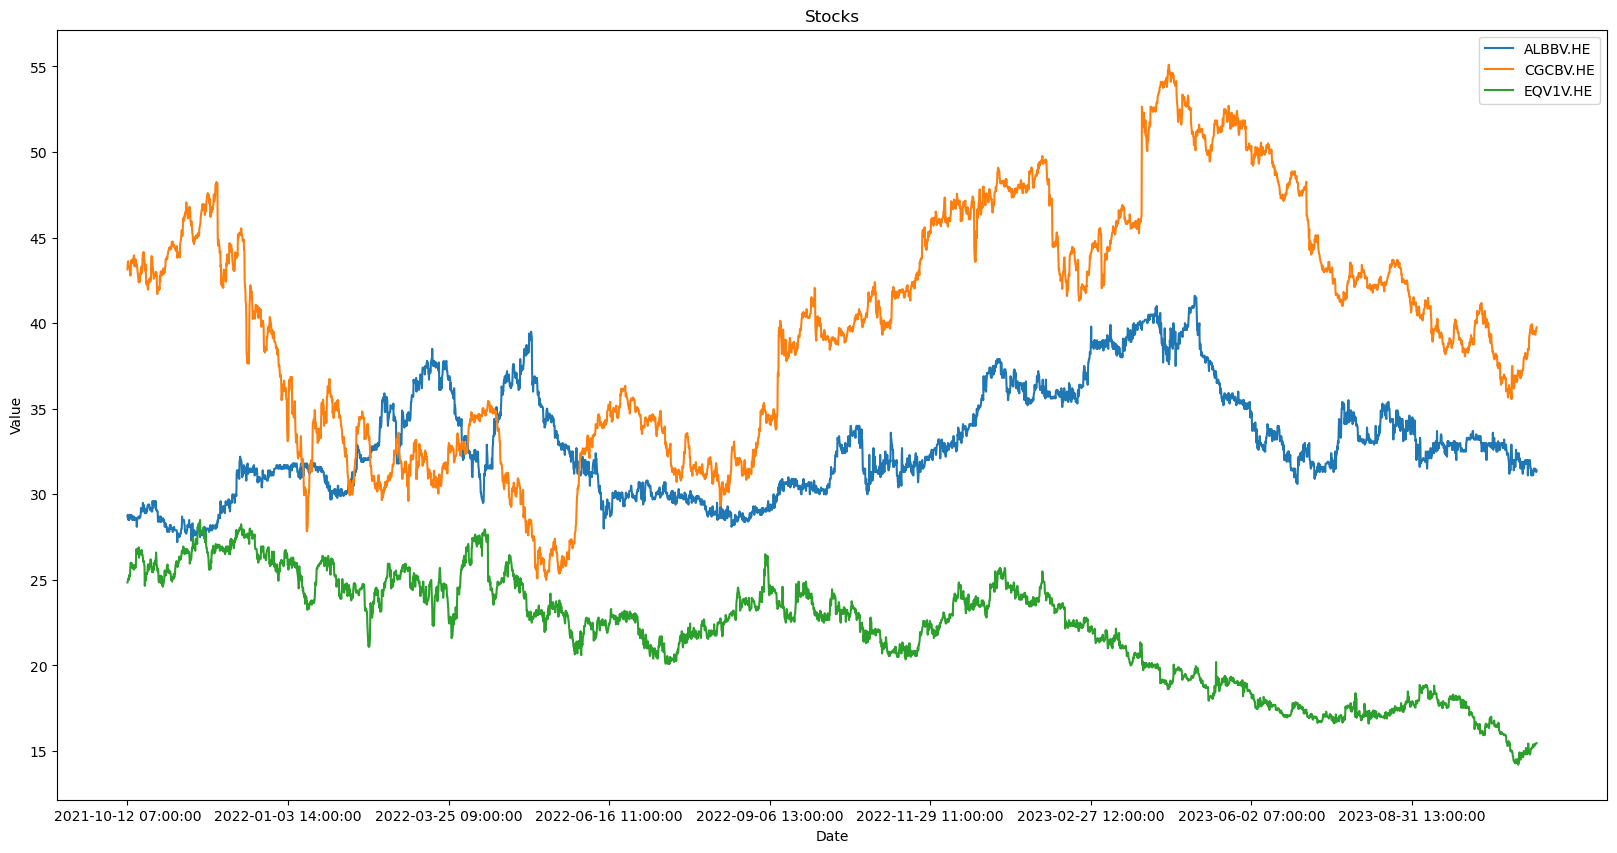

In [3]:
# Show values or not
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
for ticker in SELECTED_TICKERS[:3]:
    ax.plot(DATAFRAME.index, DATAFRAME[ticker], label=ticker)
# Change xticks
ax.set_xticks(DATAFRAME.index[::500])
ax.legend()
plt.show()

In [4]:
# If we are predicting the next price, we just minmax scale the data
TEST_FRAC = 0.2

df = DATAFRAME.copy()
if HAS_TIMEDELTA:
    td_col = df["Time Delta"]
    df.drop("Time Delta", axis=1, inplace=True)
diff_df = df.diff()
# The first row is NaN, so lets copy the second row there
diff_df.iloc[0, :] = diff_df.iloc[1, :]
# Add back the Time Delta column
if HAS_TIMEDELTA:
    diff_df["Time Delta"] = td_col
    # Make Time Delta the first column
    cols = diff_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    diff_df = diff_df[cols]
transformed_df = diff_df

# Now the transformed_df contains the data that is input to the model
# The original price data is in DATAFRAME
print(f"Dataframe shape: {df.shape}")
print(f"Transformed df shape: {transformed_df.shape}")


Dataframe shape: (4389, 14)
Transformed df shape: (4389, 14)


In [5]:
# Reload modules
%load_ext autoreload
%autoreload 2

from stock_modules.stock_transform import create_batch_xy
MHOURS = 48
CHANGE_THRESHOLD = 0.002
def update_global_mhours(new_mhours):
    global MHOURS, X_train, Y_train, X_test, Y_test, X_og, Y_og
    MHOURS = new_mhours
    print(f"MHOURS is now {MHOURS}")
    print(f"Recalculating X and Y data...")
    # Batch X data into sequences of length MHOURS (from T to T+n)
    # Label Y data as 0, 1, 2 for down, flat, up
    # We give the data in the original format, so that the labels can be calculated
    _, Y = create_batch_xy(MHOURS,
                        DATAFRAME,
                        overlap=True,
                        y_updown=False,
                        y_direction=True,
                        threshold=CHANGE_THRESHOLD,
                        to_onehot=True,
                        create_labels=True,
                        )

    # Here instead, we can give the differenced data, because we don't need to calculate the labels
    X,_ = create_batch_xy(MHOURS,
                            transformed_df,
                            overlap=True,
                            create_labels=False,
                            )
    
    rand_indicies = np.random.permutation(X.shape[0])
    X = X[rand_indicies,:,:]
    Y = Y[rand_indicies,:,:]

    # Swap 2nd and 3rd axes in Y to reshape it to (n_samples, 3,nstocks)
    Y = np.swapaxes(Y, 1, 2)

    X_og = X.copy()
    Y_og = Y.copy()

    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    test_sz = int(X.shape[0] * TEST_FRAC)

    # Split the data into train and test sets
    X_train = X[:-test_sz,:,:]
    Y_train = Y[:-test_sz,:,:]
    X_test = X[-test_sz:,:,:]
    Y_test = Y[-test_sz:,:,:]

update_global_mhours(MHOURS)

print(f"One input shape: {X_train[0].shape}")
print(f"One output shape: {Y_train[0].shape}")

print(f"Example input: \n {X_train[0]}")
print(f"Example output: \n {Y_train[0]}")

# Count the number of ups/downs/flats in Y_train
print(f"Y_train: {Y_train}")
print(f"Number of down classes: {np.sum(Y_train[:,0,:])}")
print(f"Number of flat classes: {np.sum(Y_train[:,1,:])}")
print(f"Number of up classes: {np.sum(Y_train[:,2,:])}")


MHOURS is now 48
Recalculating X and Y data...
[[55.95000076 41.81999969 35.68999863 ... 36.45999908 24.85000038
  39.15000153]
 [55.79999924 41.72000122 35.63000107 ... 36.59999847 24.95000076
  39.20000076]
 [55.70000076 42.06000137 35.40000153 ... 36.40000153 25.
  39.5       ]
 ...
 [22.81999969 31.82999992 36.90999985 ... 22.60000038 15.43999958
  24.        ]
 [22.89999962 31.84000015 37.13000107 ... 22.65999985 15.46000004
  23.70000076]
 [23.02000046 31.89999962 37.18999863 ... 22.78000069 15.46000004
  24.04999924]]

            Batched 'histories_arr' ((4389, 14)) to 'X'
            ((4341, 48, 14)) and 'Y' ((4341, 14, 3))
            
[[-0.15000153 -0.09999847 -0.05999756 ...  0.13999939  0.10000038
   0.04999924]
 [-0.15000153 -0.09999847 -0.05999756 ...  0.13999939  0.10000038
   0.04999924]
 [-0.09999847  0.34000015 -0.22999954 ... -0.19999695  0.04999924
   0.29999924]
 ...
 [-0.04000092  0.29999924  0.00999832 ...  0.01000023  0.0199995
  -0.10000038]
 [ 0.07999992  0.0


            Batched 'histories_arr' ((4389, 14)) to 'X'
            ((4341, 48, 14)) and 'Y' ((4341, 14, 3))
            
X shape: (4341, 48, 14)
Y shape: (4341, 3, 14)
One input shape: (48, 14)
One output shape: (3, 14)
Example input: 
 [[ 0.22000122 -0.25       -0.20000076 -0.41999817 -0.04999924 -0.30000305
   0.         -0.20000076 -0.40000153 -0.30000305  0.         -0.17000008
  -0.04999924  0.35000038]
 [ 0.52000046 -0.05999756  0.          0.04999924 -0.15000153  0.07000351
   0.39999962  0.29999924  0.30000305  0.20000076 -0.10000038  0.01000023
   0.10000038 -0.30000114]
 [-0.47999954 -0.11000061 -0.07999802 -0.13000107 -0.09999847 -0.01000214
  -0.39999962  0.09999847 -0.06000137 -0.29999924  0.          0.
  -0.10000038  0.14999962]
 [ 0.20000076 -0.04999924 -0.12000275  0.15000153  0.25        0.11000061
  -1.39999962  0.30000305 -0.18000031  0.04999924  0.          0.08999825
  -0.29999924  0.25      ]
 [ 0.15999985  0.09999847 -0.25999832  0.21999741  0.04999924 -0.0099

In [6]:
from stock_modules.stock_ml import (SkipTDLoss, MultiSoftmaxLoss, MultiAccuracy)
LOSS_FUN = MultiSoftmaxLoss() if not HAS_TIMEDELTA else SkipTDLoss(MultiSoftmaxLoss())


def get_direction_pred_model(hp):
    """ Returns a model that predicts the direction of the stock price.
    """
    # Input shape is (nhours, nstocks)
    input_shape = (MHOURS, X_train.shape[2])
    # Output shape is (3, nstocks)
    output_shape = (3, X_train.shape[2])

    inputs = tf.keras.layers.Input(shape=input_shape)

    nlstm_layers = hp.Int("nlstm_layers", min_value=1, max_value=3, step=1)
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=128, step=32)
    use_bidirectional = hp.Boolean("use_bidirectional")
    # Add LSTM layers
    x = inputs
    for i in range(nlstm_layers):
        if use_bidirectional:
            x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(x)
        else:
            x = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(x)

    # Flatten the output
    ndense_layers = hp.Int("ndense_layers", min_value=1, max_value=3, step=1)
    dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    x = tf.keras.layers.Flatten()(x)
    for i in range(ndense_layers):
        x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    # Output layer
    outputs = tf.keras.layers.Dense(output_shape[0]*output_shape[1], activation="linear")(x)
    outputs = tf.keras.layers.Reshape(output_shape)(outputs)
    # apply aoftmax to the columns
    outputs = tf.keras.layers.Softmax(axis = 1)(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    use_amsgrad = hp.Boolean("use_amsgrad")
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=use_amsgrad),
                    loss=LOSS_FUN,
                    metrics=[MultiAccuracy(has_timedelta=HAS_TIMEDELTA)])
    return model

In [7]:
%load_ext autoreload
%autoreload 2
# Tune the hyperparameters
import keras_tuner as kt

PATIENCE = 20
EPOCHS = 200
BATCH_SIZE = 256
DO_HYPERPARAMETER_TUNING = True

# Create a callback to stop training early
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=PATIENCE,
                                                restore_best_weights=True)

if DO_HYPERPARAMETER_TUNING:
    # Create a tuner
    objective = kt.Objective("val_multi_accuracy", direction="max")
    tuner = kt.Hyperband(get_direction_pred_model,
                        objective=objective,
                        max_epochs=EPOCHS,
                        factor=5,
                        directory=MODEL_PATH,
                        project_name=f"direction_prediction_{MHOURS}"
                        )

    # Train the model
    tuner.search(X_train,
                Y_train,
                epochs=200,
                batch_size=BATCH_SIZE,
                validation_split=0.2,
                callbacks=[early_stopping])

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()
    # save the model
    best_model.save("best_model.h5")
    model = best_model
else:
    from stock_modules.stock_ml import create_direction_prediction_model
    # Train a model once
    model = create_direction_prediction_model(MHOURS, X_train.shape[2])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=LOSS_FUN,
                    metrics=[MultiAccuracy(has_timedelta=HAS_TIMEDELTA)]
                    )
    print(model.summary())
    
    model.fit(X_train,
              Y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_split=0.2,
              callbacks=[early_stopping]
              )

# Evaluate the model
loss, acc = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss}, test accuracy: {acc}")

Y_pred = model.predict(X_test)
if HAS_TIMEDELTA:
    Y_pred = Y_pred[:,1:]




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-12-04 22:09:31.834992: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-12-04 22:09:32.256956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-04 22:09:32.261441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-04 22:09:32.2

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 14)]          0         
                                                                 
 batch_normalization (BatchN  (None, 48, 14)           56        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 48, 64)            20224     
                                                                 
 lstm_1 (LSTM)               (None, 48, 16)            5184      
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216     
                                                             

2023-12-04 22:09:32.572409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-04 22:09:32.575215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-04 22:09:32.578892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None
Epoch 1/200


2023-12-04 22:09:33.351999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-04 22:09:33.354025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-04 22:09:33.355671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - ETA: 0s - loss: 1.0972 - multi_accuracy: 0.3548

/home/akseli/anaconda3/envs/adaml/lib/python3.9/site-packages/keras/engine/training.py:2448: UserWarning: Metric MultiAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
2023-12-04 22:09:50.392783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-04 22:09:50.395680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/

11/11 [==============================] - 20s 1s/step - loss: 1.0972 - multi_accuracy: 0.3548 - val_loss: 1.0952 - val_multi_accuracy: 0.3573
Epoch 2/200
11/11 [==============================] - 6s 533ms/step - loss: 1.0916 - multi_accuracy: 0.3661 - val_loss: 1.0935 - val_multi_accuracy: 0.3668
Epoch 3/200
11/11 [==============================] - 6s 581ms/step - loss: 1.0872 - multi_accuracy: 0.3731 - val_loss: 1.0933 - val_multi_accuracy: 0.3732
Epoch 4/200
11/11 [==============================] - 5s 457ms/step - loss: 1.0834 - multi_accuracy: 0.3782 - val_loss: 1.0960 - val_multi_accuracy: 0.3778
Epoch 5/200
11/11 [==============================] - 5s 433ms/step - loss: 1.0798 - multi_accuracy: 0.3819 - val_loss: 1.0958 - val_multi_accuracy: 0.3815
Epoch 6/200
11/11 [==============================] - 6s 554ms/step - loss: 1.0758 - multi_accuracy: 0.3852 - val_loss: 1.0992 - val_multi_accuracy: 0.3849
Epoch 7/200
11/11 [==============================] - 7s 613ms/step - loss: 1.0712 - 

2023-12-04 22:12:20.949743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-04 22:12:20.951606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-04 22:12:20.953061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

28/28 [==============================] - 3s 73ms/step


In [8]:
print("Y_pred: \n", Y_pred)
print("Y_test: \n", Y_test)

# Calculate the accuracy of up-down-flat predictions
# So predict the up/down of each stock, at each time on the test data (Y_pred)
# and compare it to the true values (Y_test)
for stock_idx in range(Y_pred.shape[2] -1 if HAS_TIMEDELTA else Y_pred.shape[2]):
    # Get the up/down/flat predictions for the stock
    direction_preds = Y_pred[:,:,stock_idx]
    #print(f"direction_preds: \n {direction_preds}")
    # Get the true up/down/flat values for the stock
    direction_true = Y_test[:,:,stock_idx]
    # Get the predicted up/down/flat class
    direction_preds = np.argmax(direction_preds, axis=1)
    # Get the true up/down/flat class
    direction_true = np.argmax(direction_true, axis=1)
    # Calculate the accuracy
    accuracy = np.sum(direction_preds == direction_true) / len(direction_preds)
    print(f"Up/Down/Flat accuracy for stock {IND_CONVERSION[stock_idx]}: {accuracy}")


Y_pred: 
 [[[0.3672377  0.36065218 0.2855562  ... 0.3050101  0.32649195 0.3189966 ]
  [0.31638116 0.31967393 0.4256801  ... 0.38997984 0.32649195 0.36200672]
  [0.31638116 0.31967393 0.2887637  ... 0.3050101  0.3470161  0.3189966 ]]

 [[0.3744939  0.33571324 0.28188354 ... 0.30490312 0.3242299  0.306679  ]
  [0.31275302 0.3321434  0.43623292 ... 0.39019376 0.3242299  0.38664192]
  [0.31275302 0.3321434  0.28188354 ... 0.30490312 0.35154012 0.306679  ]]

 [[0.3593353  0.3502102  0.28398934 ... 0.29696628 0.32102624 0.31361   ]
  [0.32033235 0.3315529  0.43202132 ... 0.40784335 0.32102624 0.3727801 ]
  [0.32033235 0.31823695 0.28398934 ... 0.29519036 0.3579475  0.31361   ]]

 ...

 [[0.34340367 0.34771904 0.27995545 ... 0.30809563 0.32967463 0.3016201 ]
  [0.32829815 0.32449335 0.44008917 ... 0.38380873 0.32967463 0.39675978]
  [0.32829815 0.3277876  0.27995545 ... 0.30809563 0.3406508  0.3016201 ]]

 [[0.3631937  0.3562333  0.28211012 ... 0.30588177 0.32452637 0.31796288]
  [0.31840312 

In [9]:

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_price_model,
                               strategy_mask_from_updown_model,
                               strategy_mask_from_direction_model)

# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 4th stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test, optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
print(transformed_np_arr_test[0:2,:])
prediction_trading_mask = strategy_mask_from_direction_model(transformed_np_arr_test, MHOURS, model)

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 2nd stock: \n {prediction_trading_mask[:,2]}")
if HAS_TIMEDELTA:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test[:,1:], prediction_trading_mask)
else:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test, prediction_trading_mask)
print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 4th stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

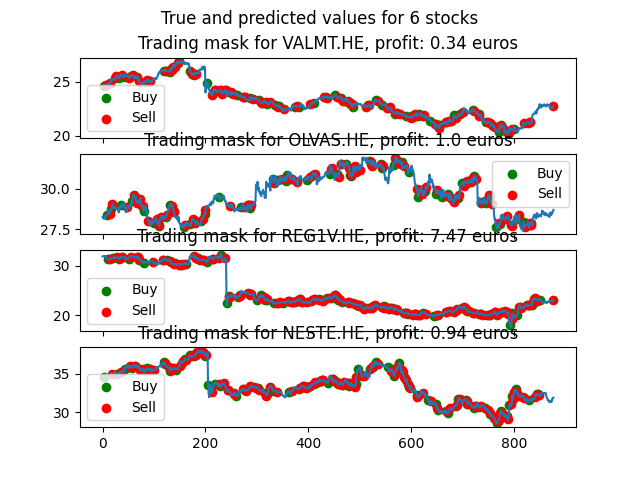

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: title={'center': 'Trading mask for VALMT.HE, profit: 0.34 euros'}>,
        <Axes: title={'center': 'Trading mask for OLVAS.HE, profit: 1.0 euros'}>,
        <Axes: title={'center': 'Trading mask for REG1V.HE, profit: 7.47 euros'}>,
        <Axes: title={'center': 'Trading mask for NESTE.HE, profit: 0.94 euros'}>],
       dtype=object))

In [15]:
%matplotlib widget
from stock_modules.stock_plot import plot_strategy_based_on_predictions,plot_mask_and_data
stock_indices = np.random.choice(np.arange(len(IND_CONVERSION)), 4, replace=False)
part_mask = prediction_trading_mask[:,stock_indices]

if HAS_TIMEDELTA:
    part_price = np_arr_test[:,1:][:,stock_indices]
else:
    part_price = np_arr_test[:,stock_indices]
ind_conversion = {si : IND_CONVERSION[i] for si, i in enumerate(stock_indices)}
plot_mask_and_data(part_mask, part_price, ind_conversion)